In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import zipfile

sys.path.append('../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

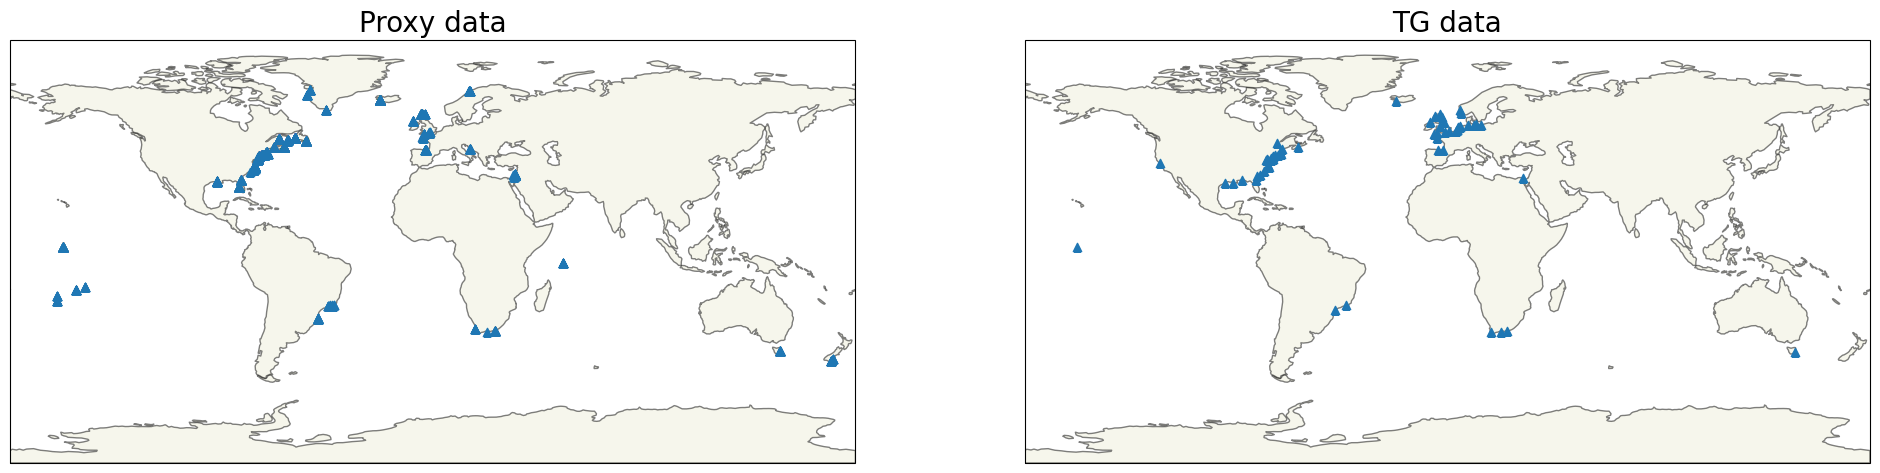

In [162]:
#load the proxy data
proxy_data = pd.read_csv('IFILES/RSL_All_17Mar2020.tsv', sep='\t', header=0, encoding= 'unicode_escape')
trainfirsttime = -1000
proxy_data = proxy_data[proxy_data['Age (CE)']>trainfirsttime]

TG_ID = pd.read_excel('IFILES/TG_ID.xlsx',skiprows=np.arange(1,4))

TG_data_folder = '../Data/TG_data/'

if len(os.listdir(TG_data_folder))<5:
    with zipfile.ZipFile(TG_data_folder+'TG_data.zip', 'r') as zip_ref:
        zip_ref.extractall(TG_data_folder)
site_file = pd.read_table(TG_data_folder+'/filelist.txt',delimiter=';',header=None)
selection_index = np.array([i in list(TG_ID['PSMSL ID']) for i in site_file.iloc[:,0]])
selected_sites = site_file.iloc[selection_index,:]

plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.scatter(proxy_data['Longitude (¡E)'],proxy_data['Latitude (¡N)'],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax2.set_title('Proxy data',fontsize=20)

ax1 = plt.subplot(122,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax1.scatter(selected_sites.iloc[:,2],selected_sites.iloc[:,1],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax1.set_title('TG data',fontsize=20);

**Load results from Hay et al., 2015**

In [165]:
import scipy.io as sio
gslfile = os.path.join('IFILES', 'Hay2015_KFandGP_GMSL.mat')

Haydat = sio.loadmat(gslfile)
Hay = {}

Hay['Y'] = Haydat['KF_GMSL'][0]
Hay['dY'] = np.sqrt(np.diag(Haydat['KF_GMSL_var']))
Hay['Ycv'] = Haydat['KF_GMSL_var']
Hay['datid'] = np.zeros_like(Hay['Y'])
Hay['time1'] = Haydat['tt_KF'][:]
Hay['time2'] = Hay['time1']
Hay['meantime'] = Hay['time1']
Hay['lat'] = np.ones_like(Hay['Y']) * 1e6
Hay['long'] = Hay['lat']
Hay['compactcorr'] = np.zeros_like(Hay['Y'])
Hay['limiting'] = np.zeros_like(Hay['Y'])
Hay['istg'] = np.ones_like(Hay['Y'])
Hay['siteid'] = 0
Hay['sitenames'] = ['Hay_KF_GMSL']
Hay['sitecoords'] = [1e6, 1e6]
Hay['sitelen'] = len(Hay['Y'])

# Smooth Hay et al curve
Hayavgwin = 10
Haystep = 10
HayGSL = Hay.copy()
HayGSL['time1'] = np.arange(1885, 2006, Haystep)
HayGSL['time2'] = HayGSL['time1']
HayGSL['meantime'] = HayGSL['time1']
M = np.abs(np.subtract.outer(HayGSL['time1'], Hay['time1'])) <= (Hayavgwin / 2)
M = M[:,0,:]
M = M / np.sum(M, axis=1, keepdims=True)
HayGSL['Y'] = M @ Hay['Y']
HayGSL['Ycv'] = M @ Hay['Ycv'] @ M.T
HayGSL['dY'] = np.sqrt(np.diag(HayGSL['Ycv']))
HayGSL['datid'] = np.zeros_like(HayGSL['Y'])
HayGSL['lat'] = np.ones_like(HayGSL['Y']) * 1e6
HayGSL['long'] = HayGSL['lat']
HayGSL['compactcorr'] = np.zeros_like(HayGSL['Y'])
HayGSL['limiting'] = np.zeros_like(HayGSL['Y'])
HayGSL['istg'] = np.ones_like(HayGSL['Y'])


**Load three old TG data**

In [166]:
import os
from scipy.sparse import dia_matrix

# old tide gauges

TGold = {
    'datid': [],
    'meantime': [],
    'Y': [],
    'dY': [],
    'lat': [],
    'long': [],
    'siteid': [],
    'sitenames': [],
    'sitecoords': [],
    'sitelen': [],
    'time1': [],
    'time2': [],
    'limiting': [],
    'compactcorr': [],
    'istg': [],
    'Ycv': None
}

for ppp in range(1, 4):
    if ppp == 1:
        dat = pd.read_csv(os.path.join('IFILES', 'amsterdam.sea.level.txt'), delim_whitespace=True,header=None)
        wsite = 'AMSTERDAM_OLD'
        wcurid = 5001
        wlat = [52.3667]
        wlong = [4.9000]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 1].values
    elif ppp == 2:
        dat = pd.read_csv(os.path.join('IFILES', 'Kronstadt_ReportsFGI_Bogdanov_appendix.csv'))
        wsite = 'KRONSTADT_OLD'
        wcurid = 5002
        wlat = [59.98]
        wlong = [29.77]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values
    elif ppp == 3:
        dat = pd.read_csv(os.path.join('IFILES', 'ekman_2003_stockholm.csv'),skiprows=1)
        wsite = 'STOCKHOLM_OLD'
        wcurid = 5003
        wlat = [59.32]
        wlong = [18.08]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values

    TGold['datid'].extend(wdatid)
    TGold['meantime'].extend(wtime)
    TGold['Y'].extend(wY)
    TGold['dY'] = np.ones(len(TGold['Y'])) * 3
    TGold['lat'].extend(np.ones_like(wY) * wlat)
    TGold['long'].extend(np.ones_like(wY) * wlong)
    TGold['siteid'].extend(np.ones_like(wY) * wcurid)
    TGold['sitenames'].append(wsite)
    TGold['sitecoords'].append([wlat[0], wlong[0]])
    TGold['sitelen'].append(len(wY))

TGold['time1'] = TGold['meantime']
TGold['time2'] = TGold['meantime']
TGold['limiting'] = np.zeros_like(TGold['datid'])
TGold['compactcorr'] = np.zeros_like(TGold['datid'])
TGold['istg'] = np.ones_like(TGold['datid'])
TGold['Ycv'] = dia_matrix((TGold['dY']**2, 0), shape=(len(TGold['Y']), len(TGold['Y'])))


**Load Gaussian Process Smoothed TG data**

Note that here we use the same TG data as we did in the other Notebook for Kopp et al., 2016, so the TG data could be slightly different compared to Walker et al., 2022.

In [167]:
new_TG_rsl_data = pd.read_csv('IFILES/Decadal_TG.csv')
old_TG_rsl_data = pd.read_csv('IFILES/Decadal_old_TG.csv')

In [170]:
#combined proxy and TG data 

X = np.hstack((proxy_data['Age (CE)'],new_TG_rsl_data['Year (CE)'],old_TG_rsl_data['Year (CE)'],HayGSL['meantime']))
y = np.hstack((proxy_data['RSL (m)'],new_TG_rsl_data['RSL (mm)']/1000,old_TG_rsl_data['RSL (mm)']/1000,
                HayGSL['Y']/1000))
proxy_x_sigma = (proxy_data['Age +2s'] + proxy_data['Age -2s'])/4
X_sigma = np.hstack((proxy_x_sigma,np.zeros(len(new_TG_rsl_data)),np.zeros(len(old_TG_rsl_data)),
                    np.zeros(len(HayGSL['meantime']))))

proxy_y_sigma = (proxy_data['RSL +1s'] + proxy_data['RSL -1s'])/2
y_sigma = np.hstack((proxy_y_sigma,new_TG_rsl_data['RSL std (mm)']/1000,
                    old_TG_rsl_data['RSL std (mm)']/1000,HayGSL['dY']/1000))

longitude = np.hstack([proxy_data['Longitude (¡E)'],new_TG_rsl_data['Longitude'],old_TG_rsl_data['Longitude'],
                    HayGSL['long']/2000])
longitude[longitude<0]+=360
latitude = np.hstack([proxy_data['Latitude (¡N)'],new_TG_rsl_data['Latitude'],old_TG_rsl_data['Latitude'],
                    HayGSL['lat']/2000])

X_all = np.vstack([X,latitude,longitude]).T

#filter out data with too old age or too large uncertainty
filter_1 = (X<-1000) 
filter_2 = X_sigma>=100
filter_all = filter_1 | filter_2
X = X[~filter_all]
y = y[~filter_all]
X_sigma = X_sigma[~filter_all]
y_sigma = y_sigma[~filter_all]
X_all = X_all[~filter_all]
longitude = longitude[~filter_all]
latitude = latitude[~filter_all]


**Load ICE5G Model**

In [171]:
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]

#interpolate ICE5G linear rate to all sites
from scipy import interpolate
long_index = longitude<360

GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (longitude[long_index], latitude[long_index]), method='linear')

y_no_GIA = y.copy()
y_no_GIA[long_index] = y_no_GIA[long_index] - GIA_rate*(X[long_index]-2010)/1000

In [154]:
from tqdm.notebook import tqdm

def SVI_NI_optm(gpr,x_sigma,num_iteration=1000,lr=0.05,decay_r = 1,step_size=100,gpu=False):
    '''
    A funciton to optimize the hyperparameters of a GP model using SVI

    ---------Inputs-----------
    gpr: a GP model defined by pyro GPR regression
    x_sigma: one sigma uncertainty for input data
    num_iteration: number of iterations for the optimization
    lr: learning rate for the optimization
    step_size: step size for the learning rate to decay. 
    A step size of 100 with a decay rate of 0.9 means that the learning rate will be decrease 10% for every 100 steps.
    gpu: whether use gpu to accelerate training 
    ---------Outputs-----------
    gpr: a GP model with optimized hyperparameters
    track: a dictionary of loss
    '''
    
    #clear the param store
    pyro.clear_param_store()
    #convert the model to double precision
    gpr = gpr.double()
    #define the optimiser
    optimizer = torch.optim.Adam(gpr.parameters(), lr=lr)
    #define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_r)
    #define the loss function
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    #do the optimisation
    track_list = []
    N = len(gpr.X)
    if gpr.noise.dim()==1:
        y_sigma = gpr.noise**0.5
    elif gpr.noise.dim()==2:
        y_sigma = gpr.noise.view(-1)[:: N + 1]**0.5


    for i in tqdm(range(num_iteration)):
        #update vertical noise based on gradient
        if gpu:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True).cuda()
        else:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True)
        y_mean, _ = gpr(x_test.double(), full_cov=False)
        y_mean.sum().backward(retain_graph=True)
        if gpu:
            y_rate = x_test.grad.cuda()
        else:
            y_rate = x_test.grad
        if y_rate.ndim>1: y_rate = y_rate[:,0]
        new_sigma = torch.sqrt((y_rate**2*(x_sigma)**2)+y_sigma**2)
        if gpr.noise.dim()==1:
            gpr.noise = torch.tensor(new_sigma**2)
        elif gpr.noise.dim()==2:
            gpr.noise.view(-1)[:: N + 1] = torch.tensor(new_sigma**2)
            
        scheduler.step()
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        gpr.set_mode("guide")
        tem_para =  []
        
        #use fast global kernel's lengthscale for fast regional and local non-linear kernel
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale
        #local non linear fast         
        gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern0.lengthscale

        #use fast global kernel's lengthscale for slow regional and local non-linear kernel
        #regional non linear slow
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale
        #local non linear slow
        gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern0.kern1.lengthscale
        
        #set same spatial length scale for reigonal and local kernel 
        gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale
        gpr.kernel.kern0.kern0.kern0.kern1.kern1.s_lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale

        #set local variance equal to regional variance
        gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance
        gpr.kernel.kern0.kern0.kern0.kern1.kern0.variance = gpr.kernel.kern0.kern0.kern0.kern0.kern0.kern1.kern0.variance

        

        for i2 in pyro.get_param_store().values():
            if i2.numel()==1:
                tem_para.append(i2.item())
            else:
                for i3 in i2:
                    tem_para.append(i3.item())
        
        track_list.append([loss.item(),*tem_para])
    
    #generate columns names for the track list
    col_name = ['loss' ]

    for i in (dict(pyro.get_param_store()).keys()):
        if pyro.get_param_store()[i].numel() ==1:
            col_name.append(i[7:].replace('_map',''))
        else:
            for i2 in range(pyro.get_param_store()[i].numel()):
                col_name.append(i[7:].replace('_map','')+'_'+str(i2))
    #convert the track list to a dataframe
    track_list=pd.DataFrame(track_list,columns=col_name)

    return gpr,track_list

In [156]:
# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel fast
global_kernel_f = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel_f.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(100.)))
global_kernel_f.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-4)))

#define global temporal kernel slow
global_kernel_s = PSTHM.Matern32(input_dim=1,geo=False)
global_kernel_s.set_prior("lengthscale", dist.Uniform(torch.tensor(100.), torch.tensor(1000.)))
global_kernel_s.set_prior("variance", dist.Uniform(torch.tensor(1e-4), torch.tensor(5e-1)))

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = gp.kernels.Polynomial(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-3)))
regional_linear_temporal_kernel.set_prior("bias", dist.Uniform(torch.tensor(2010.**2-0.5), torch.tensor(2010.**2+0.5)))
regional_linear_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.20)))
regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define fast regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_f = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,geo=False)
regional_nl_temporal_kernel_f.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(1e-2)))
regional_nl_spatial_kernel_f = PSTHM.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel_f.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.1), torch.tensor(0.35)))
regional_nl_kernel_f = gp.kernels.Product(regional_nl_temporal_kernel_f, regional_nl_spatial_kernel_f)

#define slow regionally non-linar spatio-temporal kernel 
regional_nl_temporal_kernel_s = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,geo=False)
regional_nl_temporal_kernel_s.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(5e-2)))
regional_nl_spatial_kernel_s = PSTHM.Matern21(input_dim=1,s_lengthscale =regional_nl_spatial_kernel_f.s_lengthscale,geo=True)
regional_nl_kernel_s = gp.kernels.Product(regional_nl_temporal_kernel_s, regional_nl_spatial_kernel_s)

#define fast locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_f = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_f.lengthscale,
                                            variance =regional_nl_temporal_kernel_f.variance ,geo=False)
local_nl_spatial_kernel_f = PSTHM.Matern21(input_dim=1,geo=True)
local_nl_spatial_kernel_f.set_prior("s_lengthscale", dist.Uniform(torch.tensor(1e-4), torch.tensor(1e-3)))
local_nl_kernel_f = gp.kernels.Product(local_nl_temporal_kernel_f, local_nl_spatial_kernel_f)

#define slow locally non-linar spatio-temporal kernel 
local_nl_temporal_kernel_s = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel_s.lengthscale,
                                            variance =regional_nl_temporal_kernel_s.variance ,geo=False)
local_nl_spatial_kernel_s = PSTHM.Matern21(input_dim=1,lengthscale = local_nl_spatial_kernel_f.s_lengthscale,geo=True)
local_nl_kernel_s = gp.kernels.Product(local_nl_temporal_kernel_s, local_nl_spatial_kernel_s)

#define white-noise kernel
sp_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=True,geo=False)
sp_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

s_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=False,geo=True)
s_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

#define constant offset kernel
constant_kernel = gp.kernels.Constant(input_dim=1)
constant_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-1)))

combined_sp_kernel = gp.kernels.Sum(global_kernel_f,global_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel_f)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel_f)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,local_nl_kernel_s)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,constant_kernel)

N = len(X_all)
noise_cov = torch.zeros(N,N).double()
noise_cov.view(-1)[:: N + 1] += 1e-5 + torch.tensor(y_sigma**2)
noise_cov[np.outer(longitude>360 ,longitude>360 )] =  torch.tensor(HayGSL['Ycv']/1000**2).flatten()

gpr = PSTHM.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)

# Empirical bayes optimization, default iteration is 1000
gpr,track_list = SVI_NI_optm(gpr,x_sigma=torch.tensor(X_sigma),num_iteration=100,lr=0.5,decay_r = 0.8,step_size=10)
torch.save(gpr, 'Walker_et_al_2022_GMSL_model')

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 